In [1]:
import argparse
from typing import OrderedDict
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from modules.vgg import vgg16
from modules.vgg import vgg16_bn
from modules.resnet import resnet50
from modules.resnet import resnet152
from modules.resnet import resnet152
from modules.resnet import resnet152
from modules.resnet import resnet152
from util import *
import render
import imageio
from torch.autograd import Variable
from baselines.gradcam import GradCam
from einops import rearrange
import copy
from util import *
import matplotlib.pyplot as plt
import pickle
import os
import tqdm
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.rise import rise
from torchray.attribution.gradient import gradient
from torchray.attribution.guided_backprop import guided_backprop
from torchray.attribution.excitation_backprop import excitation_backprop
from torchray.attribution.excitation_backprop import contrastive_excitation_backprop
from torchray.attribution.deconvnet import deconvnet
from modules.explanations import RISE
import cv2

class ImageSplitDataset(Dataset):
    """
    한개의 이미지 입력(1,C,H,W)을 채널 방향만 남기는 데이터셋.
    shuffle should be false
    """

    def __init__(self,input_image):
        self.input_image = input_image
        self.image_h = input_image.shape[-2]
        self.image_w = input_image.shape[-1]
        self.input_image = torch.squeeze(input_image,dim=0) # image -> C,H,W


    def __len__(self):

        return self.image_h * self.image_w
        pass

    def __getitem__(self,idx):
        _h = idx // self.image_h
        _w = idx % self.image_w
        out = torch.zeros_like(self.input_image)
        out[:,_h,_w] = self.input_image[:,_h,_w]
        return out

        

def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

def visualize(relevances, img_name):
    heatmap = np.sum(relevances, axis=3)
    heatmaps = []
    for h, heat in enumerate(heatmap):
        maps = render.hm_to_rgb(heat, scaling=3, sigma=1, cmap='seismic')
        heatmaps.append(maps)
        imageio.imsave('./result/heatmap/' + img_name + '.jpg', maps, vmax=1, vmin=-1)



/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
with open("./bulk_imnet_fgsm.pkl", 'rb') as f:
    dict = pickle.load(f)



In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.cuda.set_device(device) 
#device = 'cpu'
num_workers = 0
batch_size = 1

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
data_name = 'val_nolabel'

# define data loader

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./data/' + data_name,
                            transforms.Compose([
                                transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                normalize,
                            ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True)
import matplotlib.pyplot as plt
# saliency_layer = 29
# bp = GradCam(model, target_layer=saliency_layer)

In [4]:
x,y = next(iter(val_loader))

In [5]:
str(int(y))

'0'

In [3]:

def make_dir(directory_name):
    if not directory_name:
        return ''
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    if directory_name[-1] != '/':
        directory_name = directory_name + '/'

    return directory_name

In [4]:
from modules.resnet import Bottleneck

In [8]:
# def make_sanity(layer,model,device):
#     if isinstance(layer,nn.Sequential):
#         for blk in reversed(layer._modules.values()):
#             make_sanity(blk,model,device)
#     elif isinstance(layer,Bottleneck):
#         for blk in reversed(layer._modules.values()):
#             make_sanity(blk,model,device)
#     elif isinstance(layer,nn.BatchNorm2d):
#         nn.init.constant_(layer.weight,1)
#         nn.init.constant_(layer.bias,0)
#         nn.init.constant_(layer.running_mean,0)
#         nn.init.constant_(layer.running_var,1)
        
#     elif isinstance(layer,nn.Conv2d):
#         infer_pkg = InferencePkg()
#         infer_pkg.device = device
#         name = layer.name
#         nn.init.kaiming_uniform_(layer.weight)
#         #nn.init.constant_(layer.weight,0.001)
#         _ = model(x,infer_pkg)
#         y = torch.zeros_like(_)
#         idx = 13
#         y[0,idx] = 1
#         simmap = model.get_pixel_cont(x,y,infer_pkg,lambda x:x).squeeze().detach().cpu()
#         out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
#         plt.imshow(out)
#         plt.imsave(f'sanity_check_resnet_{name}.png',out)
#     else:
#         return


In [5]:
def make_sanity(layer,model,device):
    if isinstance(layer,nn.Sequential):
        for blk in layer._modules.values():
            make_sanity(blk,model,device)
    elif isinstance(layer,Bottleneck):
        for blk in layer._modules.values():
            make_sanity(blk,model,device)
    elif isinstance(layer,nn.BatchNorm2d):
        nn.init.constant_(layer.weight,1)
        nn.init.constant_(layer.bias,0)
        nn.init.constant_(layer.running_mean,0)
        nn.init.constant_(layer.running_var,1)
        
    elif isinstance(layer,nn.Conv2d):
        infer_pkg = InferencePkg()
        infer_pkg.device = device
        name = layer.name
        nn.init.kaiming_uniform_(layer.weight)
        #nn.init.constant_(layer.weight,0.001)

        #plt.imsave(f'sanity_check_resnet_{name}.png',out)
    else:
        return

In [6]:
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device

In [7]:
img = 'data/imagenet/images/16.JPEG'
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, img)
x = x.to(device)

In [9]:
for m in model_org.children():
    make_sanity(m,model_org,device)

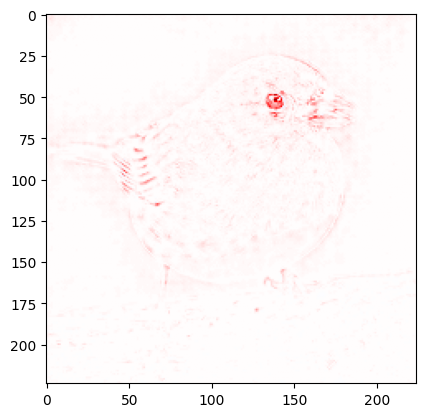

In [10]:
_ = model_org(x,infer_pkg)
y = torch.zeros_like(_)
idx = 13
y[0,idx] = 1
simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x).squeeze().detach().cpu()
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)
#plt.imsave('post_activation.png',out)

In [9]:
simmap.sum()

tensor(17.8310)

In [ ]:
#bias bunbae jaedaero in resnet

In [ ]:
torch.float32

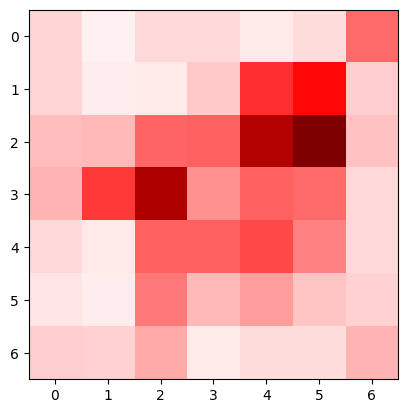

In [10]:
simmap = infer_pkg.simmaps['resnet50.layer4.1']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

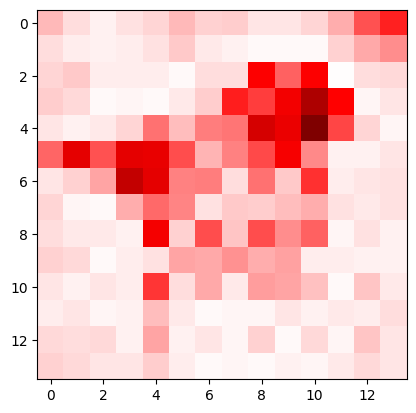

In [11]:
simmap = infer_pkg.simmaps['resnet50.layer4.0']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

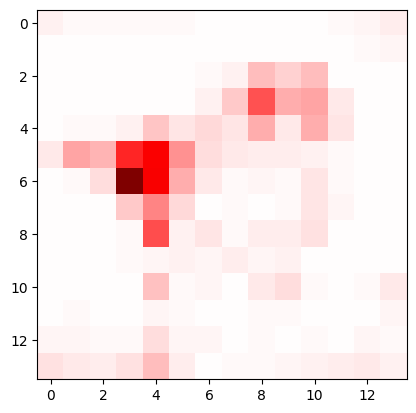

In [12]:
simmap = infer_pkg.simmaps['resnet50.layer3.1']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

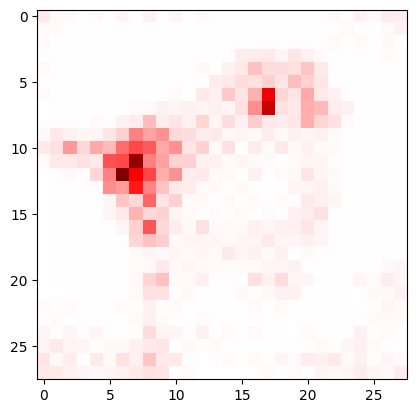

In [13]:
simmap = infer_pkg.simmaps['resnet50.layer3.0']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

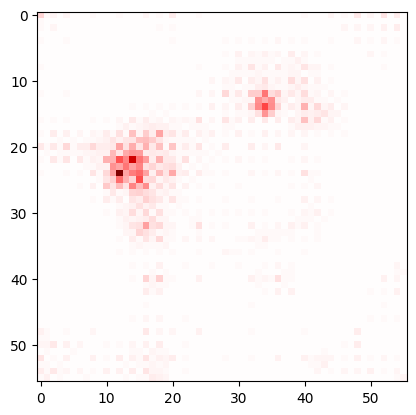

In [10]:
simmap = infer_pkg.simmaps['resnet50.layer1.2']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

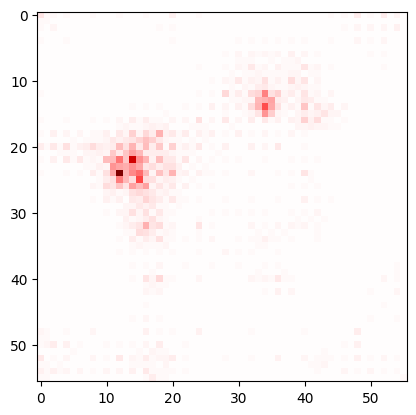

In [11]:
simmap = infer_pkg.simmaps['resnet50.layer1.1']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

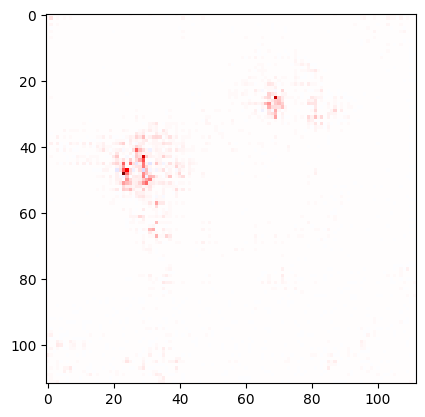

In [12]:
simmap = infer_pkg.simmaps['resnet50.relu']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [6]:
infer_pkg = InferencePkg()
infer_pkg.device = device
#x,y = next(iter(val_loader))
img = 'data/imagenet/images/1.jpg'
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, img)
x = x.to(device)

In [6]:
def torch_to_image(tensor, mean=0, std=1):
    """
    Helper function to convert torch tensor containing input data into image.
    """
    if len(tensor.shape) == 4:
        img = tensor.permute(0, 2, 3, 1)

    img = img.contiguous().squeeze().detach().cpu().numpy()

    img = img * std.reshape(1, 1, 3) + mean.reshape(1, 1, 3)
    return np.clip(img, 0, 1)

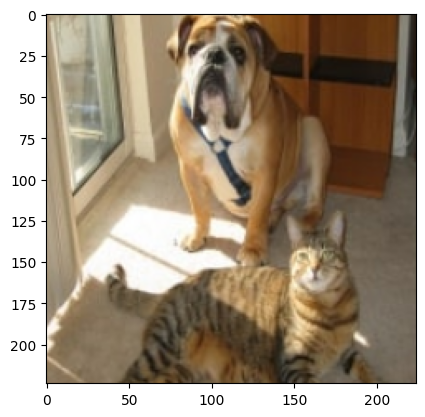

In [7]:
plt.imshow(torch_to_image(x,data_mean,data_std))

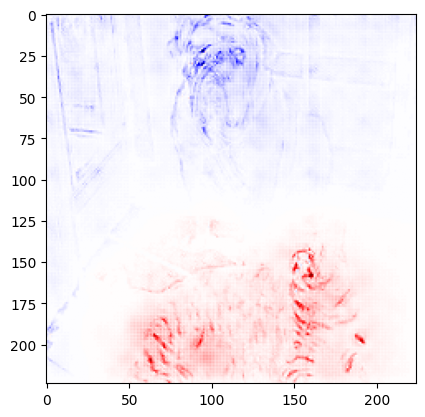

In [8]:
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
layer = model_org.fc
_ = model_org(x,infer_pkg)
y = torch.zeros_like(_)
idx = 281
y[0,idx] = 1
simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x-x.mean()).squeeze().detach().cpu()
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

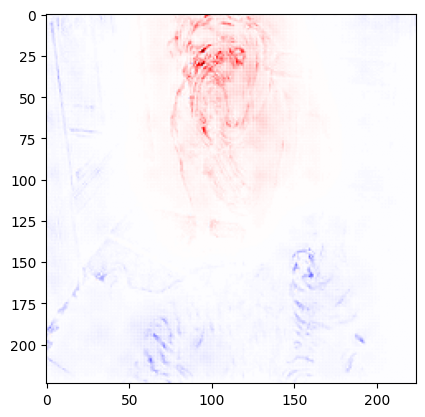

In [9]:
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
layer = model_org.fc
_ = model_org(x,infer_pkg)
y = torch.zeros_like(_)
idx = 243
y[0,idx] = 1
simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x-x.mean()).squeeze().detach().cpu()
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

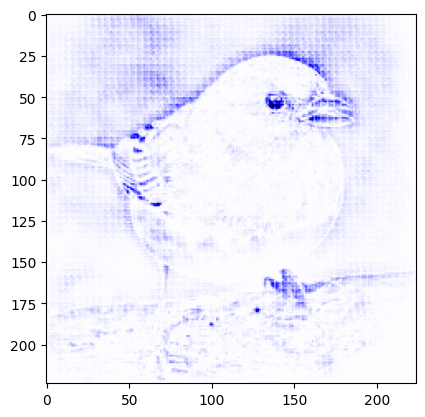

In [17]:
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
layer = model_org.fc
if isinstance(layer,nn.Linear):
    name = layer.name
    nn.init.xavier_uniform_(layer.weight)
    nn.init.constant_(layer.bias,0)

_ = model_org(x,infer_pkg)
y = torch.zeros_like(_)
idx = 13
y[0,idx] = 1
simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x).squeeze().detach().cpu()
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)
plt.imsave(f'sanity_check_resnet_logit.png',out)

#for layer in reversed(model_org._modules.values()):
for layer in reversed(model_org._modules.values()):

    make_sanity(layer,model_org,device)
    

In [31]:
#resnet50EBPtonpy
'exp_{:05}-{:05}.npy'
exp_simmap = []
model = torchvision.models.resnet50(pretrained=True).to(device)
model = model.eval()

for i,(x,y) in tqdm.tqdm(enumerate(val_loader)):
    x = x.to(device)
    y_pred = model(x)
    idx = y_pred.max(1)[1]
    y = torch.zeros_like(y_pred)
    y[0,idx] = 1
    simmap = contrastive_excitation_backprop(
    model,
    x,
    idx,
        saliency_layer=model.layer1,
    contrast_layer=model.layer4,
    classifier_layer=model.fc,
    ).squeeze().detach().cpu().numpy()
    simmap = cv2.resize(simmap, (224,224))
    simmap = torch.tensor(simmap)

    exp_simmap.append(simmap)
    if len(exp_simmap) == 5000:
        exp_numpy = torch.stack(exp_simmap).numpy()
        start_num = i+1 - 5000
        end_num = i
        start_num = str(start_num)
        end_num = str(end_num)
        for i in range(5):
            if len(start_num) != 5:
                start_num = '0' + start_num
            if len(end_num) != 5:
                end_num = '0' + end_num
        np.save(f'exp_{start_num}-{end_num}_resnet_EBP.npy',exp_numpy)
        exp_simmap = []
        break


/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
4999it [02:29, 33.38it/s]


In [13]:
#rise to npy

exp_simmap = []
model = torchvision.models.resnet50(pretrained=True).to(device)
model = model.eval()

for i,(x,y) in tqdm.tqdm(enumerate(val_loader)):
    x = x.to(device)
    
    with torch.no_grad():
        y_pred = model(x)
        idx = y_pred.max(1)[1]
        y = torch.zeros_like(y_pred)
        y[0,idx] = 1
        simmap = rise(model, x)[:, idx].squeeze().cpu()

    exp_simmap.append(simmap)
    if len(exp_simmap) == 5000:
        exp_numpy = torch.stack(exp_simmap).numpy()
        start_num = i+1 - 5000
        end_num = i
        start_num = str(start_num)
        end_num = str(end_num)
        for i in range(5):
            if len(start_num) != 5:
                start_num = '0' + start_num
            if len(end_num) != 5:
                end_num = '0' + end_num
        np.save(f'exp_{start_num}-{end_num}_resnet_rise.npy',exp_numpy)
        exp_simmap = []
        break


/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
4999it [8:22:50,  6.04s/it]


In [6]:
#resnet50tonpy
'exp_{:05}-{:05}.npy'
exp_simmap = []
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
with torch.no_grad():
    for i,(x,y) in tqdm.tqdm(enumerate(val_loader)):
        x = x.to(device)
        y_pred = model_org(x,infer_pkg)
        idx = y_pred.max(1)[1]
        y = torch.zeros_like(y_pred)
        y[0,idx] = 1
        simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x-x.mean()).squeeze().detach().cpu()
        exp_simmap.append(simmap)
        if len(exp_simmap) == 5000:
            exp_numpy = torch.stack(exp_simmap).numpy()
            start_num = i+1 - 5000
            end_num = i
            start_num = str(start_num)
            end_num = str(end_num)
            for i in range(5):
                if len(start_num) != 5:
                    start_num = '0' + start_num
                if len(end_num) != 5:
                    end_num = '0' + end_num
            np.save(f'exp_{start_num}-{end_num}_resnet_deduct.npy',exp_numpy)
            exp_simmap = []
            break


2371it [24:53,  1.57it/s]

In [ ]:
#resnet50tonpy
'exp_{:05}-{:05}.npy'
exp_simmap = []
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
with torch.no_grad():
    for i,(x,y) in tqdm.tqdm(enumerate(val_loader)):
        x = x.to(device)
        y_pred = model_org(x,infer_pkg)
        idx = y_pred.max(1)[1]
        y = torch.zeros_like(y_pred)
        y[0,idx] = 1
        simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x).squeeze().detach().cpu()
        exp_simmap.append(simmap)
        if len(exp_simmap) == 5000:
            exp_numpy = torch.stack(exp_simmap).numpy()
            start_num = i+1 - 5000
            end_num = i
            start_num = str(start_num)
            end_num = str(end_num)
            for i in range(5):
                if len(start_num) != 5:
                    start_num = '0' + start_num
                if len(end_num) != 5:
                    end_num = '0' + end_num
            np.save(f'exp_{start_num}-{end_num}_resnet_normal.npy',exp_numpy)
            exp_simmap = []
            break


In [5]:
#resnet50_simmapatlayer1tonpy
'exp_{:05}-{:05}.npy'
exp_simmap = []
model_org = resnet50(pretrained=True,name='resnet50').to(device)
model_org = model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
with torch.no_grad():
    for i,(x,y) in tqdm.tqdm(enumerate(val_loader)):
        x = x.to(device)
        y_pred = model_org(x,infer_pkg)
        idx = y_pred.max(1)[1]
        y = torch.zeros_like(y_pred)
        y[0,idx] = 1
        simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x-x.mean())
        simmap = infer_pkg.simmaps['resnet50.layer1.2'].squeeze().detach().cpu().numpy()
        simmap = cv2.resize(simmap, (224,224))
        simmap = torch.tensor(simmap)
        exp_simmap.append(simmap)
        if len(exp_simmap) == 5000:
            exp_numpy = torch.stack(exp_simmap).numpy()
            start_num = i+1 - 5000
            end_num = i
            start_num = str(start_num)
            end_num = str(end_num)
            for i in range(5):
                if len(start_num) != 5:
                    start_num = '0' + start_num
                if len(end_num) != 5:
                    end_num = '0' + end_num
            np.save(f'exp_{start_num}-{end_num}_resnet_lesscoarse_deduct.npy',exp_numpy)
            exp_simmap = []
            break
         

4999it [53:15,  1.56it/s]


In [6]:
#resnet50_simmapatlayer1tonpy
'exp_{:05}-{:05}.npy'
exp_simmap = []

with torch.no_grad():
    for i,(x,y) in tqdm.tqdm(enumerate(val_loader)):
        x = x.to(device)
        y_pred = model_org(x,infer_pkg)
        idx = y_pred.max(1)[1]
        y = torch.zeros_like(y_pred)
        y[0,idx] = 1
        simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x)
        simmap = infer_pkg.simmaps['resnet50.layer1.2'].squeeze().detach().cpu().numpy()
        simmap = cv2.resize(simmap, (224,224))
        simmap = torch.tensor(simmap)
        exp_simmap.append(simmap)
        if len(exp_simmap) == 5000:
            exp_numpy = torch.stack(exp_simmap).numpy()
            start_num = i+1 - 5000
            end_num = i
            start_num = str(start_num)
            end_num = str(end_num)
            for i in range(5):
                if len(start_num) != 5:
                    start_num = '0' + start_num
                if len(end_num) != 5:
                    end_num = '0' + end_num
            np.save(f'exp_{start_num}-{end_num}_resnet_lesscoarse_normal.npy',exp_numpy)
            exp_simmap = []
            break

4999it [52:46,  1.58it/s]


In [12]:
model_org.layer1

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu1): ReLU(inplace=True)
    (relu2): ReLU(inplace=True)
    (relu3): ReLU(inplace=True)
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [10]:
t = np.load('exp_0-4999.npy')

In [11]:
t.shape

(5000, 224, 224)

In [7]:
start_num = 0
start_num = str(start_num)
for i in range(5):
    if len(start_num) != 5:
        start_num = '0' + start_num


In [8]:
start_num

'00000'

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.cuda.set_device(device) 
#device = 'cpu'
num_workers = 0
batch_size = 1

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
data_name = 'val/'

# define data loader

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./data/' + data_name,
                            transforms.Compose([
                                transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                normalize,
                            ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True)
import matplotlib.pyplot as plt
# saliency_layer = 29
# bp = GradCam(model, target_layer=saliency_layer)

In [4]:
def tensor_imshow(inp, title=None, **kwargs):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Mean and std for ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)

In [11]:
#resnet50 expl

out_dir = './resnet_expl/'
for i,(x,idx) in enumerate(val_loader):
    x = x.to(device)
    y_pred = model_org(x,infer_pkg)
    y = torch.zeros_like(y_pred)
    y[0,idx] = 1
    simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x).squeeze().detach().cpu()
    fig = plt.figure()
    tensor_imshow(x[0].cpu())
    plt.axis('off')
    plt.imshow(simmap, cmap='jet', alpha=0.5)
    dir = out_dir + str(int(idx)) + '/'
    make_dir(dir)
    plt.savefig(dir + str(i)+'.png')
    plt.close(fig)

: 

: 

In [ ]:
out_dir = './expl/'
for i,(x,y) in enumerate(val_loader):
    x = x.to(device)
    X = x
    input = (X - X.min() ) / ( X.max() - X.min())
    img = (input).detach().cpu().squeeze().transpose(0,1).transpose(1,2)
    dir = out_dir + str(int(y)) + '/'
    make_dir(dir)
    plt.imsave(dir + str(i)+'_org.png',out)

In [31]:
model_org = resnet50(pretrained=True,name='resnet50').cuda()
model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
x,y = next(iter(val_loader))
img = 'data/imagenet/images/collie3.jpeg'
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, img)
x = x.to(device)

In [21]:
out[0,243]

tensor(12.9189, device='cuda:1', grad_fn=<SelectBackward0>)

In [45]:
# x[0,:,125:,140:200] = 0
#x[0,:,0:150,75:130] = 0
out = model_org(x,infer_pkg)
idx = out.max(1)[1]
y_zero = torch.zeros_like(out)
y_zero[0,idx] = 1
simmap = model_org.get_pixel_cont(x,y_zero,infer_pkg,lambda x:x - x.mean(
),rule=None)

In [42]:
idx

tensor([231], device='cuda:1')

In [23]:
fig = plt.figure()
tensor_imshow(x[0].cpu())
plt.axis('off')
plt.imshow(simmap.squeeze().cpu().numpy(),cmap='jet', alpha=0.5)
plt.savefig('1.png')
plt.close(fig)

NameError: name 'tensor_imshow' is not defined

<Figure size 640x480 with 0 Axes>

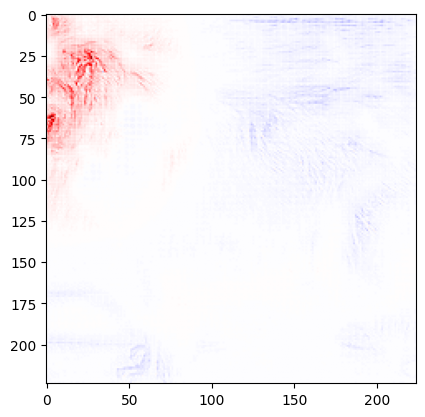

In [46]:

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

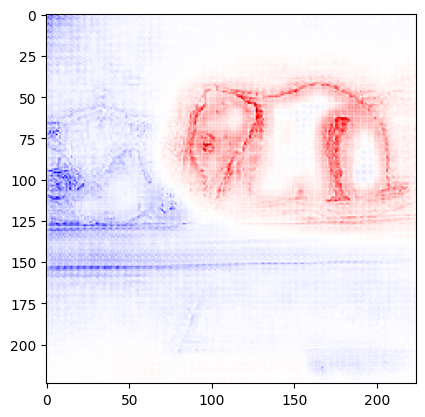

In [29]:

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

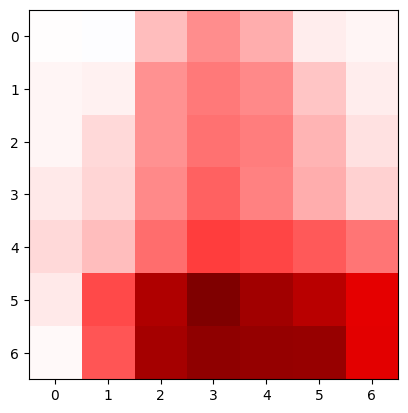

In [103]:
out = render.hm_to_rgb(infer_pkg.simmaps['true_avgpool'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)
plt.imsave('avgpool.png',out)

In [5]:
np.load('exp_05000-09999_vgg_deduct.npy')

ValueError: Cannot load file containing pickled data when allow_pickle=False

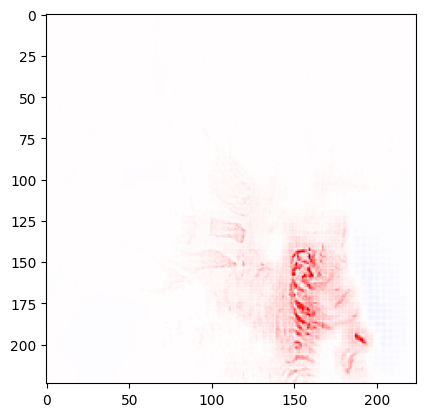

In [100]:
extern_simmap = torch.zeros_like(infer_pkg.simmaps['resnet50.layer4.2.relu2']).to(device)
extern_simmap[0,5,5] = 1
target_layer_name = 'resnet50.layer4.2.relu2'
erf = model_org.get_ERF(x,extern_simmap,infer_pkg,target_layer_name=target_layer_name)
out = render.hm_to_rgb(erf.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)
plt.imsave('ERF_(5,5).png',out)

In [109]:
for i in range(100):
    __ = F.softmax(model_org(x,_inf),dim=1)
    print(__[0,idx])
    topk_idx = simmap.flatten().topk(100)[-1]
    x = x.view(1,3,224*224)
    x[0,:,topk_idx] = 0
    simmap.flatten()[topk_idx] = -torch.inf
    _inf = InferencePkg()
    _inf.device = device
    x = x.view(1,3,224,224)
    


tensor([0.4305], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.2973], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.2962], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.4452], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.4284], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.2969], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.3392], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.3707], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.2540], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.1384], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.1243], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0656], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0729], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0294], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0090], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0069], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.0106], device='cuda:0', grad_f

In [38]:
topk_idx = simmap.flatten().topk(100)[-1]
t = x.view(1,3,224*224)
t[0,:,topk_idx] = 0

In [6]:
model_org.ideal_feature_vector = None
X_pure = model_org.get_ideal_feature_vector(infer_pkg)
_ = InferencePkg()
_.device = device
pure_out = model_org.classifier[3](X_pure,_)
pure_out = model_org.classifier[4](pure_out,_)
pure_out = model_org.classifier[5](pure_out,_)
pure_out = model_org.classifier[6](pure_out,_)

building ideal feature vectors...


/home/sangyu/Desktop/Master/TRD/TRD/modules/vgg.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pure_out_2 = F.softmax(pure_out)
/home/sangyu/Desktop/Master/TRD/TRD/modules/vgg.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pure_out_2 = F.softmax(pure_out)
/home/sangyu/Desktop/Master/TRD/TRD/modules/vgg.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pure_out_2 = F.softmax(pure_out)


KeyboardInterrupt: 

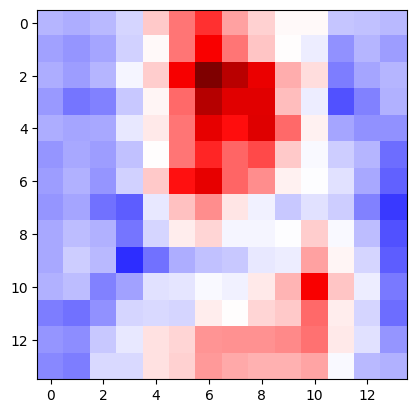

In [26]:
out = render.hm_to_rgb(infer_pkg.simmaps['vgg16.features.27'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

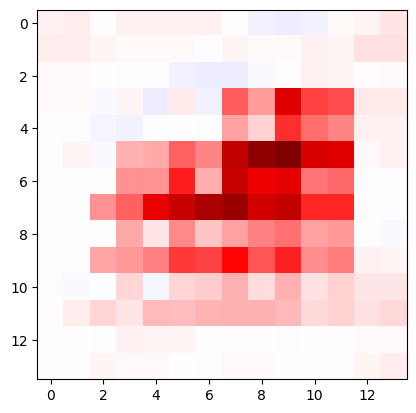

In [9]:
out = render.hm_to_rgb(infer_pkg.simmaps['classifier'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [31]:
target_layer_name = 'vgg16.features.27'
n,h,w = infer_pkg.simmaps[target_layer_name].shape
extern_simmap = torch.zeros((1,h,w)).cuda()
extern_simmap[0,2,6] = 1
simmap = model_org.get_ERF(x,extern_simmap,infer_pkg,target_layer_name='vgg16.features.27')

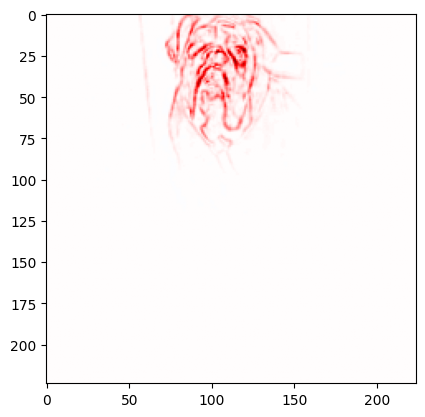

In [32]:
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [92]:
infer_pkg.simmaps['']

KeyError: ''

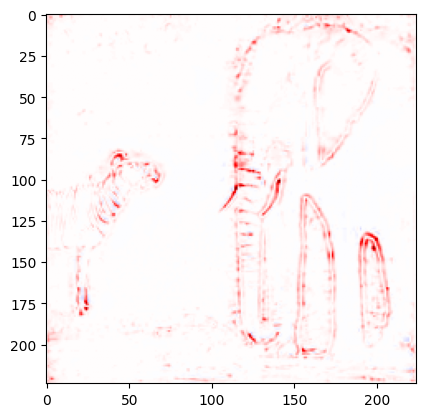

In [8]:
infer_pkg.simmaps['classifier']

tensor([[[ 0.1826,  0.1454,  0.7365,  0.8008,  0.4565,  0.1990,  0.2617],
         [ 0.1507,  0.0697,  2.0448,  1.4036,  1.6015,  0.2646,  0.0674],
         [ 0.1762,  0.0405,  1.7999,  1.9873,  2.2536,  0.5218,  0.1674],
         [ 0.1444,  0.0888,  1.1804,  1.0136,  0.8841, -0.0031,  0.1539],
         [ 0.2072,  0.0860,  0.5035,  0.5486,  0.0134,  0.0939,  0.2314],
         [ 0.0948,  0.1851,  0.2077,  0.0963,  0.0680,  0.2442,  0.2298],
         [ 0.0326,  0.1096,  0.5295,  0.5026,  0.6082,  0.3978,  0.3421]]])

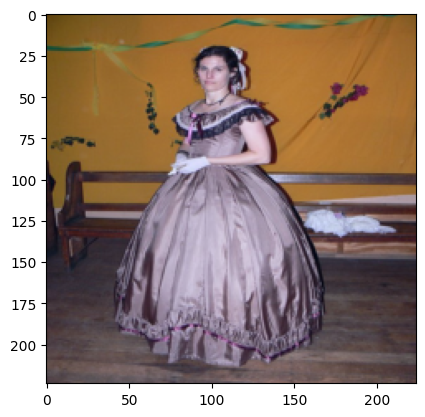

In [10]:
X = x
input = (X - X.min() ) / ( X.max() - X.min())
img = (input).detach().cpu().squeeze().transpose(0,1).transpose(1,2)
plt.imshow(img)

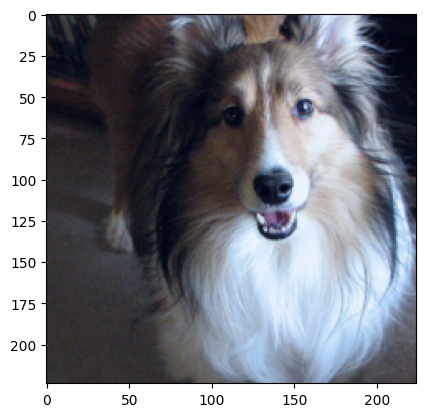

In [11]:
X = x
input = (X - X.min() ) / ( X.max() - X.min())
img = (input).detach().cpu().squeeze().transpose(0,1).transpose(1,2)
plt.imshow(img)

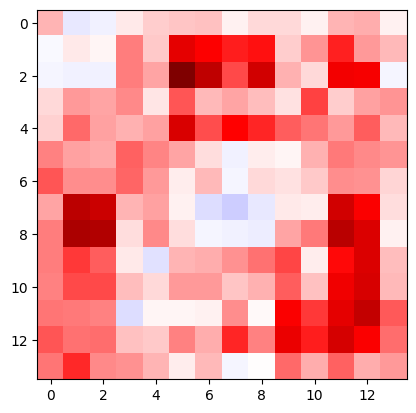

In [21]:

out = render.hm_to_rgb(infer_pkg.simmaps['classifier'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [47]:
org_out = model_org(x,infer_pkg)
y = torch.zeros_like(org_out)
org_acc, org_idx = org_out.max(1)
y = infer_pkg.output_dict['vgg16.classifier.1']
org_expl = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x - x.mean())
out = render.hm_to_rgb(org_expl.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

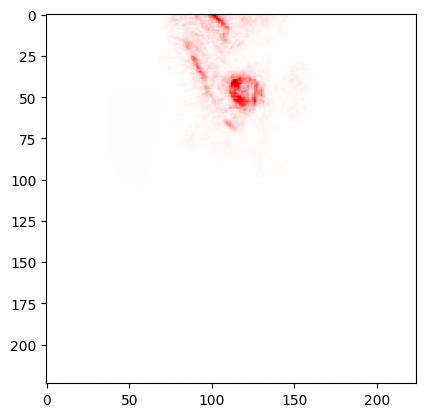

In [46]:
target_layer_name = 'vgg16.features.29'
extern_simmap = torch.zeros((1,14,14)).to(device)
extern_simmap[0,2,6] = 1
simmap = model_org.get_ERF(x,extern_simmap,infer_pkg,target_layer_name=target_layer_name)

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [5]:
X = infer_pkg.output_dict['vgg16.classifier.1'].cuda()
org_out = model_org(x,infer_pkg)
#X_pure = X.clone().detach().requires_grad_()
X_pure = torch.ones_like(X,requires_grad=True)
y = torch.zeros_like(org_out)
idx = 282
#y[:,idx] = org_out.clone().detach()[:,idx]
y[:,idx] = 1

optimizer = torch.optim.Adam([X_pure], lr=0.0005)

Loss = torch.nn.CosineEmbeddingLoss()
for i in range(30000):
    
    optimizer.zero_grad()
    pure_out = torch.clamp(X_pure,min=0)
    #pure_out = model_org.classifier[3](X_pure,infer_pkg)
    pure_out = model_org.classifier[3](pure_out,infer_pkg)
    pure_out = model_org.classifier[4](pure_out,infer_pkg)
    pure_out = model_org.classifier[5](pure_out,infer_pkg)
    pure_out = model_org.classifier[6](pure_out,infer_pkg)
    pure_out = pure_out / 20 # temperature
    pure_out_2 = F.softmax(pure_out)

    loss1 = F.mse_loss(y, pure_out_2,reduction='sum')
    loss2 = F.mse_loss(y[:,idx], pure_out_2[:,idx])
    loss = loss1 + 5 * loss2
    #loss = F.cross_entropy(pure_out,y)
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
        print(loss)


KeyError: 'vgg16.classifier.1'

In [19]:
t = model_org.classifier[0].bias

In [20]:
pure_out[0,282]

Traceback (most recent call last):
  File "/home/sangyu/anaconda3/envs/py39/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 620, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1
    Parameter containing:tensor([ 0.0341,  0.0021,  0.0217,  ..., -0.0060,  0.0480,  0.0001],       device='cuda:0', requires_grad=True)
              ^
SyntaxError: invalid syntax


tensor(14.1487, device='cuda:0', grad_fn=<SelectBackward0>)

In [25]:
X_pure.sum()

tensor(3644.7891, device='cuda:0', grad_fn=<SumBackward0>)

In [26]:
X.sum()

tensor(1782.0375, device='cuda:0')

In [27]:
t = pure_out[0,:]

In [73]:
pure_out = model_org.classifier[3](0.01 * X_pure,infer_pkg)
pure_out = model_org.classifier[4](pure_out,infer_pkg)
pure_out = model_org.classifier[5](pure_out,infer_pkg)
pure_out = model_org.classifier[6](pure_out,infer_pkg)

In [7]:
model_org.classifier.modules()

<generator object Module.modules at 0x7f5d5657e120>

NameError: name 'infer_pkg' is not defined

In [1]:
import argparse
from typing import OrderedDict
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from modules.vgg import vgg16
from modules.vgg import vgg16_bn
from modules.resnet import resnet50
from modules.resnet import resnet152
from modules.resnet import resnet152
from modules.resnet import resnet152
from modules.resnet import resnet152
from util import *
import render
import imageio
from torch.autograd import Variable
from baselines.gradcam import GradCam
from einops import rearrange
import copy
from util import *
import matplotlib.pyplot as plt
infer_pkg = InferencePkg()
device = 'cuda:1'
infer_pkg.device = device
infer_pkg.remember_input_graph = True
model_org = vgg16(pretrained=True,name='vgg16').to(device)
model_org = model_org.eval()

img = 'data/imagenet/images/1.jpg'
target_img = 'data/imagenet/images/3.jpg'
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, img)
x_target = load_image(data_mean, data_std, device, target_img)
x_adv = x.clone().detach().requires_grad_()


org_out = model_org(x,infer_pkg)
y = torch.zeros_like(org_out)
org_acc, org_idx = org_out.max(1)
y = infer_pkg.output_dict['vgg16.classifier.1']
org_expl = model_org.get_pixel_cont_simple(x,infer_pkg,lambda x:x,idx=None)
org_expl = org_expl.detach().cpu()
model_org.X_pure = None


out_target = model_org(x_target,infer_pkg)
y = torch.zeros_like(out_target)
target_acc, target_idx = out_target.max(1)
y = infer_pkg.output_dict['vgg16.classifier.1']
target_expl = model_org.get_pixel_cont_simple(x_target,infer_pkg,lambda x:x,idx=None)
target_expl = target_expl.detach()
model_org.X_pure = None

optimizer = torch.optim.Adam([x_adv], lr=0.0005)


In [2]:
model_org.classifier.name

'vgg16.classifier'

In [3]:
torch.autograd.set_detect_anomaly(True)
for i in range(4000):
   
    optimizer.zero_grad()

    # calculate loss
    
    adv_out = model_org(x_adv,infer_pkg)
    y = torch.zeros_like(adv_out)
    adv_acc, class_idx = adv_out.max(1)
    y = infer_pkg.output_dict['vgg16.classifier.1']
    adv_expl = model_org.get_pixel_cont_simple(x_adv,infer_pkg,lambda x:x,idx=None)

    loss_expl = F.mse_loss(adv_expl, target_expl)
    loss_output = F.mse_loss(adv_acc, org_acc.detach())
    total_loss = 1e13*loss_expl + 1e6*loss_output

    # update adversarial example
    total_loss.backward()
    optimizer.step()

    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

# test with original model (with relu activations)

adv_out = model_org(x_adv,infer_pkg)
y = torch.zeros_like(adv_out)
adv_acc, class_idx = adv_out.max(1)
# y[0,class_idx] = adv_out[0,class_idx]
# adv_expl = model_org.get_pixel_cont(x_adv,y,infer_pkg,lambda x:x)

Iteration 0: Total Loss: 40842.0, Expl Loss: 4.084200089238266e-09, Output Loss: 0.0
Iteration 1: Total Loss: 40870.69921875, Expl Loss: 4.087046256984195e-09, Output Loss: 2.374881660216488e-07
Iteration 2: Total Loss: 84094.15625, Expl Loss: 4.089670380125199e-09, Output Loss: 0.043197453022003174


KeyboardInterrupt: 

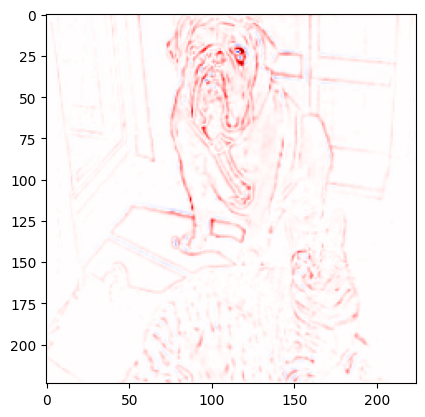

In [3]:

out = render.hm_to_rgb(org_expl.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [17]:
infer_pkg.simmaps['classifier']

tensor([[[ 0.0036,  0.0018,  0.0015,  0.0041,  0.0020,  0.0027,  0.0046],
         [ 0.0025,  0.0017,  0.0014,  0.0013, -0.0014,  0.0032,  0.0020],
         [ 0.0076,  0.0132,  0.0042,  0.0061,  0.0140,  0.0061,  0.0027],
         [ 0.0148,  0.0158,  0.0083,  0.0055,  0.0150,  0.0072,  0.0026],
         [ 0.0146,  0.0073,  0.0035,  0.0029,  0.0027,  0.0029,  0.0026],
         [ 0.0064,  0.0059,  0.0026,  0.0074,  0.0050,  0.0017,  0.0005],
         [ 0.0041,  0.0025,  0.0007,  0.0018,  0.0031,  0.0050,  0.0025]]])

In [27]:
targetlen(model_org.features)

31

In [1]:
model_org = vgg16(pretrained=True,name='vgg16').cuda()
model_org = model_org.eval()
device = 'cuda:1'
infer_pkg = InferencePkg()
infer_pkg.device = device
infer_pkg.remember_input_graph = True


img = 'data/imagenet/images/collie4.jpeg'
target_img = 'data/imagenet/images/tiger_cat.jpeg'
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, img)
x_target = load_image(data_mean, data_std, device, target_img)
x_adv = x.clone().detach().requires_grad_()


org_out = model_org(x,infer_pkg)
y = torch.zeros_like(org_out)
org_acc, org_idx = F.softmax(org_out, dim=1), torch.max(org_out, 1)[1]
y = infer_pkg.output_dict['vgg16.classifier.1']
org_idx_vector = torch.zeros_like(org_out)

org_expl = torch.abs(model_org.get_pixel_cont_simple(x,infer_pkg,contrastive_rule=lambda x:x,idx=232))
org_expl = org_expl.detach().cpu()
model_org.X_pure = None


out_target = model_org(x_target,infer_pkg)
y = torch.zeros_like(out_target)
target_acc, target_idx = out_target.max(1)
y = infer_pkg.output_dict['vgg16.classifier.1']
target_expl = torch.abs(model_org.get_pixel_cont_simple(x_target,infer_pkg,lambda x:x,idx=282))
target_expl = target_expl.detach()
model_org.X_pure = None

optimizer = torch.optim.Adam([x_adv], lr=0.0005)

NameError: name 'vgg16' is not defined

In [9]:
model_org.features[29]

ReLU(inplace=True)

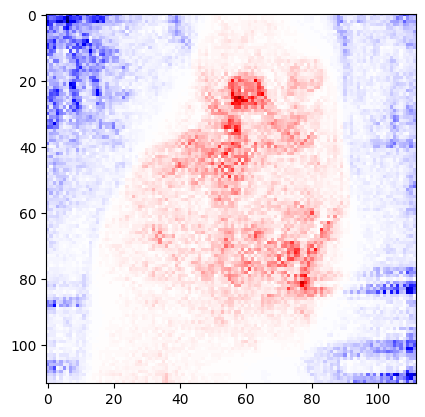

In [12]:

out = render.hm_to_rgb(infer_pkg.simmaps['vgg16.features.8'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [8]:
target_expl.sum()

tensor(98.1988, device='cuda:0')

In [20]:
model_org.features[23]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [10]:
infer_pkg.simmaps['v']

tensor(76.9944)

In [14]:
simmap = infer_pkg.simmaps['vgg16.features.22']
out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

KeyError: 'vgg16.features.22'

In [14]:

for i in range(6000):
   
    optimizer.zero_grad()

    # calculate loss
    
    adv_out = model_org(x_adv,infer_pkg)
    adv_acc, class_idx = adv_out.max(1)
   
    adv_expl = torch.abs(model_org.get_pixel_cont_simple(x_adv,infer_pkg,lambda x:x,idx=230))

    loss_expl = F.mse_loss(adv_expl, target_expl)
    loss_output = F.mse_loss(adv_acc, org_acc.detach())
    total_loss = 1e11*loss_expl + 1e6*loss_output

    # update adversarial example
    total_loss.backward()
    optimizer.step()

    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

# test with original model (with relu activations)

adv_out = model_org(x_adv,infer_pkg)
y = torch.zeros_like(adv_out)
adv_acc, class_idx = adv_out.max(1)
# y[0,class_idx] = adv_out[0,class_idx]target
# adv_expl = model_org.get_pixel_cont(x_adv,y,infer_pkg,lambda x:x)

Iteration 0: Total Loss: 1911.3944091796875, Expl Loss: 1.8571618909390963e-08, Output Loss: 5.423251786851324e-05
Iteration 1: Total Loss: 1900.1031494140625, Expl Loss: 1.8575519789010286e-08, Output Loss: 4.255125531926751e-05
Iteration 2: Total Loss: 1919.7425537109375, Expl Loss: 1.856876075123637e-08, Output Loss: 6.28666311968118e-05
Iteration 3: Total Loss: 1917.1932373046875, Expl Loss: 1.8573739879457207e-08, Output Loss: 5.981937647447921e-05
Iteration 4: Total Loss: 1884.6527099609375, Expl Loss: 1.8562937853516814e-08, Output Loss: 2.8359005227684975e-05
Iteration 5: Total Loss: 1862.0552978515625, Expl Loss: 1.8562337444905097e-08, Output Loss: 5.821584636578336e-06
Iteration 6: Total Loss: 1856.200439453125, Expl Loss: 1.8556916003831248e-08, Output Loss: 5.088659236207604e-07
Iteration 7: Total Loss: 1872.10595703125, Expl Loss: 1.854641951126723e-08, Output Loss: 1.7464048141846433e-05


KeyboardInterrupt: 

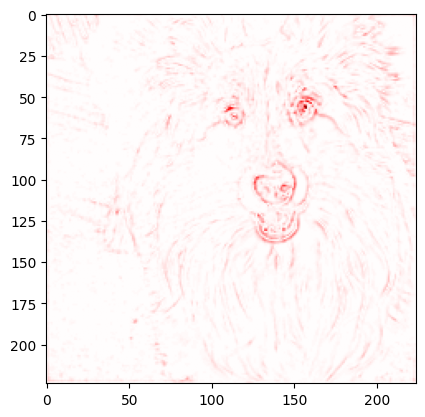

In [13]:
out = render.hm_to_rgb(adv_expl.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [21]:
target_expl.mean()

tensor(1.6274, device='cuda:0')

In [30]:
adv_expl = model_org.get_pixel_cont(x,infer_pkg,lambda x:x,idx=class_idx)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.70 GiB total capacity; 14.41 GiB already allocated; 91.06 MiB free; 14.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

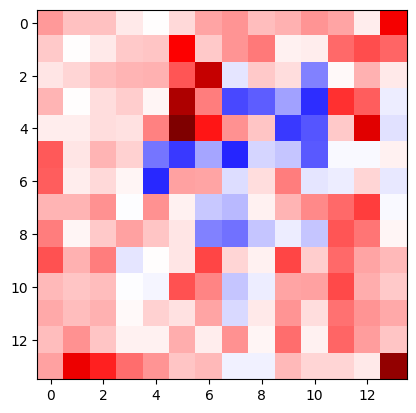

In [24]:
out = render.hm_to_rgb(infer_pkg.simmaps['classifier'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [27]:
target_layer_name = 'vgg16.features.27'
extern_simmap = torch.zeros((1,14,14)).to(device)
extern_simmap[0,9,9] = 1
simmap = model_org.get_ERF(x_adv,extern_simmap,infer_pkg,target_layer_name=target_layer_name)

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.70 GiB total capacity; 14.36 GiB already allocated; 56.62 MiB free; 14.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

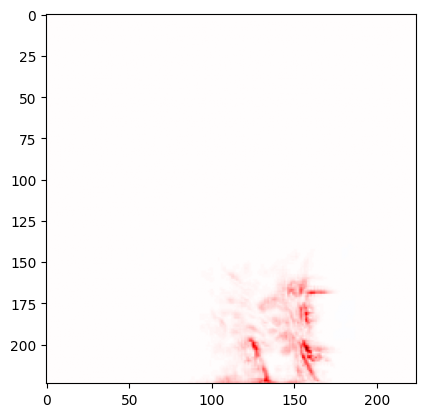

In [24]:
out_target = model_org(x_target,infer_pkg)
y = torch.zeros_like(out_target)
target_acc, target_idx = out_target.max(1)
y[0,target_idx] = out_target[0,target_idx]
target_expl = model_org.get_pixel_cont(x_target,y,infer_pkg,lambda x:x)
target_expl = target_expl.detach()



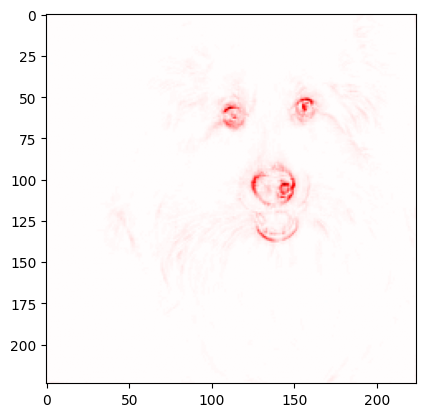

In [10]:

out = render.hm_to_rgb(org_expl.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [33]:
infer_pkg_org = InferencePkg()
infer_pkg_org.device = device
infer_pkg_org.remember_input_graph = True
adv_out = model_org(x_adv,infer_pkg)
org_out = model_org(x,infer_pkg_org)

In [53]:
model_org.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [56]:

w_p = 2
h_p = 2
maxpool = model_org.features[4]
input = infer_pkg.input_dict['vgg16.features.4']

output = infer_pkg.output_dict['vgg16.features.4']
input_sum = torch.zeros_like(output)
for _w_p in range(w_p):
    for _h_p in range(h_p):
        _input = torch.zeros_like(input)
        _input[:,:,_w_p::w_p,_h_p::h_p] = input[:,:,_w_p::w_p,_h_p::h_p]
        _input = maxpool.decomp_forward(_input,infer_pkg)
        input_sum += _input

In [58]:
input_sum

tensor([[[[0.0000, 0.7233, 0.0637,  ..., 0.9790, 0.7493, 4.0421],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6150],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5041],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7144, 1.5540],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0410, 1.6532],
          [0.0000, 0.0000, 0.0000,  ..., 0.1508, 0.0000, 1.2491]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.1306,  ..., 0.0000, 0.6567, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1259, 0.0000],
          [0.0000, 0.0462, 0.0615,  ..., 0.3537, 0.0731, 0.0209]],

         [[0.4559, 3.3901, 2.8630,  ..., 3.1917, 3.0541, 4.1567],
          [0.0000, 1.0750, 1.3824,  ..., 1.2398, 1.2202, 1.9185],
          [0.0000, 0.0000, 0.3846,  ..., 0

In [50]:
layer_name = 'vgg16.features.6'
t = infer_pkg.output_dict[layer_name]
s = infer_pkg_org.output_dict[layer_name]

In [51]:
cos = nn.CosineSimilarity()
cos(t,s)

tensor([[[0.9983, 0.9942, 0.9910,  ..., 0.9808, 0.9947, 0.9993],
         [0.9975, 0.9889, 0.9834,  ..., 0.9143, 0.9758, 0.9979],
         [0.9939, 0.9938, 0.9802,  ..., 0.7926, 0.9555, 0.9964],
         ...,
         [0.9673, 0.7572, 0.8431,  ..., 0.8817, 0.8497, 0.9741],
         [0.9754, 0.9165, 0.8369,  ..., 0.9187, 0.8597, 0.9703],
         [0.9935, 0.9805, 0.9772,  ..., 0.9796, 0.9741, 0.9936]]],
       device='cuda:0', grad_fn=<SumBackward1>)

tensor([[[0.9999, 0.9999, 0.9998,  ..., 0.9999, 0.9999, 0.9999],
         [0.9997, 0.9990, 0.9959,  ..., 0.9946, 0.9970, 0.9999],
         [0.9999, 0.9992, 0.9989,  ..., 0.9968, 0.9975, 0.9999],
         ...,
         [0.9997, 0.9925, 0.9922,  ..., 0.9869, 0.9949, 0.9990],
         [0.9997, 0.9908, 0.9845,  ..., 0.9906, 0.9912, 0.9993],
         [0.9998, 0.9996, 0.9992,  ..., 0.9997, 0.9991, 0.9997]]],
       device='cuda:0', grad_fn=<SumBackward1>)

In [23]:
org_out = model_org(x,infer_pkg)
y = torch.zeros_like(org_out)
org_acc, org_idx = org_out.max(1)
y[0,org_idx] = org_out[0,org_idx]
org_expl = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x)

RuntimeError: shape '[1, 1, 1, 4096]' is invalid for input of size 1000

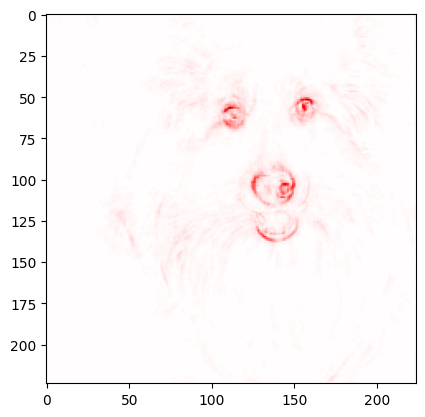

In [20]:

out = render.hm_to_rgb(adv_expl.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

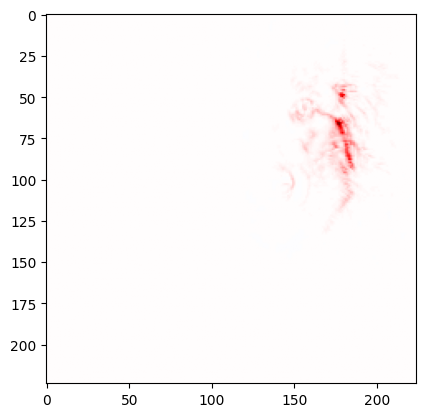

In [21]:
target_layer_name = 'vgg16.features.27'
extern_simmap = torch.zeros((1,14,14)).to(device)
extern_simmap[0,4,12] = 1
simmap = model_org.get_ERF(x,extern_simmap,infer_pkg,target_layer_name=target_layer_name)

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

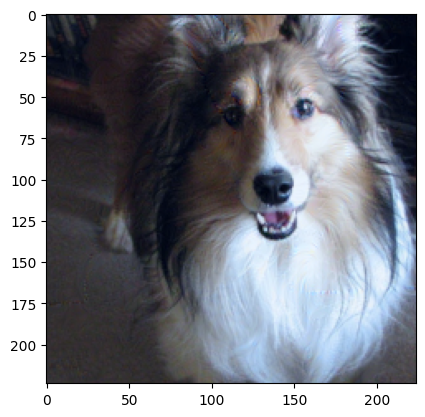

In [19]:
X = x_adv
input = (X - X.min() ) / ( X.max() - X.min())
img = (input).detach().cpu().squeeze().transpose(0,1).transpose(1,2)
plt.imshow(img)

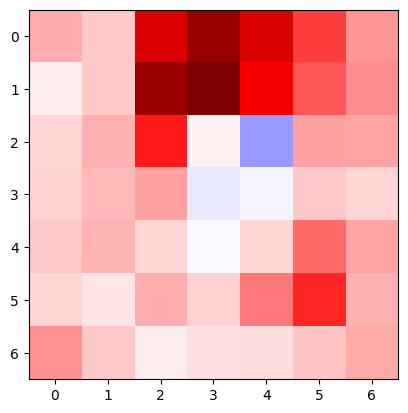

In [35]:

out = render.hm_to_rgb(infer_pkg.simmaps['classifier'].squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

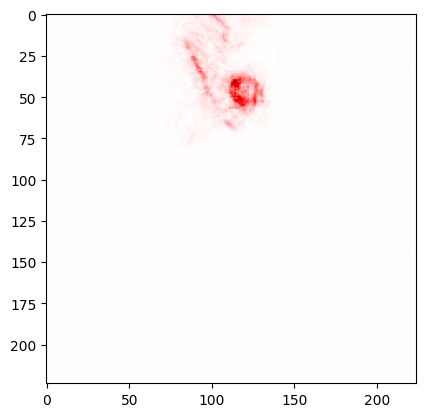

In [37]:
target_layer_name = 'vgg16.features.27'
extern_simmap = torch.zeros((1,14,14)).to(device)
extern_simmap[0,2,6] = 1
simmap = model_org.get_ERF(x_adv,extern_simmap,infer_pkg,target_layer_name=target_layer_name)

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [24]:
model_res = resnet50(pretrained=True,name='resnet50').cuda()
model_res = model_res.eval()
infer_pkg_res = InferencePkg()
infer_pkg_res.device = device
adv_out = model_res(x_adv,infer_pkg_res)
y = torch.zeros_like(adv_out)
adv_acc, class_idx = adv_out.max(1)
y[0,class_idx] = adv_out[0,class_idx]
adv_expl = model_res.get_pixel_cont(x_adv,y,infer_pkg_res,lambda x:x)

In [12]:
idx = 243
rel = torch.zeros((1,7,7),device=device)
for _h in range(7):
    for _w in range(7):
        test = torch.zeros_like(t,device=device)
        test[:,:,_h,_w] = t[:,:,_h,_w]
        bias_shrink = 49
        out = model_org.classifier.decomp_forward(test,infer_pkg,bias_shrink)
        rel[0,_h,_w] = out[0,idx]

In [13]:
o = SimmapObj()
o.simmap = rel
simmap = model_org.features.simprop2(o,infer_pkg)

UnboundLocalError: local variable 'bn' referenced before assignment

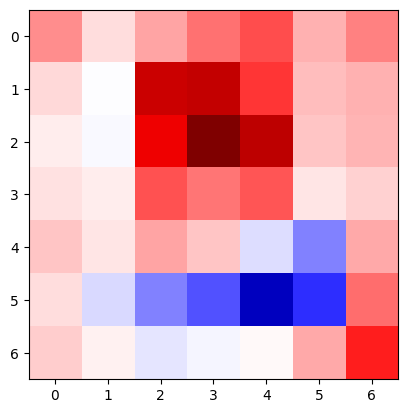

In [10]:

out = render.hm_to_rgb(rel.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [19]:
rel.sum()

tensor(11.5033, grad_fn=<SumBackward0>)

In [6]:
_.max(1)

torch.return_types.max(
values=tensor([11.5028], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([243], device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


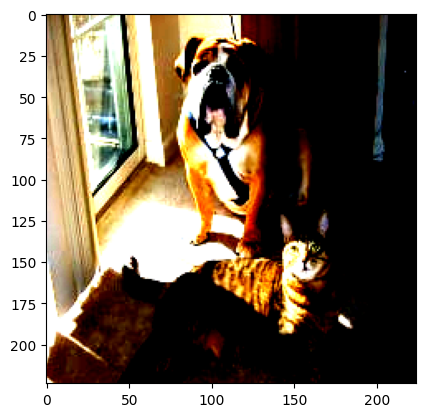

In [ ]:
img = x.squeeze().transpose(0,1).transpose(1,2)
plt.imshow(img)

In [34]:
#model_org.fc.reset_parameters()

In [35]:
# model_org.layer4[0].conv3.reset_parameters()
# model_org.layer4[0].bn3.reset_parameters()
# model_org.layer4[0].conv2.reset_parameters()
# model_org.layer4[0].bn2.reset_parameters()
# model_org.layer4[0].conv1.reset_parameters()
# model_org.layer4[0].bn1.reset_parameters()

In [36]:
# model_org.layer2[0].downsample[0].reset_parameters()
# model_org.layer2[0].downsample[0].reset_parameters()

In [10]:
x = x.to(device).requires_grad_() 
infer_pkg.remember_input_graph = True
_ = model_org(x,infer_pkg)

In [11]:
_[0,13]

tensor(15.7273, device='cuda:0', grad_fn=<SelectBackward0>)

In [12]:
_.max(1)

torch.return_types.max(
values=tensor([15.7273], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([13], device='cuda:0'))

In [7]:
type(None)

NoneType

In [13]:
y = torch.zeros_like(_)
y[0,243] = 1 # 이게 둘다 음수면 안되네!... 13방향 = 새인데 이것의 양수방향을 알고싶은거잖아..
#y[0,_.max(1)[1]] = _[0,_.max(1)[1]]
simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x-x.max()/3)

In [ ]:
model_org = resnet50(pretrained=True,name='resnet50').cuda()
model_org.eval()
infer_pkg = InferencePkg()
infer_pkg.device = device
infer_pkg.is_image_inference = True
x,y = next(iter(val_loader))

y = torch.zeros_like(_)
y[0,13] = 1 # 이게 둘다 음수면 안되네!... 13방향 = 새인데 이것의 양수방향을 알고싶은거잖아..
#y[0,_.max(1)[1]] = _[0,_.max(1)[1]]
simmap = model_org.get_pixel_cont(x,y,infer_pkg,lambda x:x)

img = 'data/imagenet/images/1.jpg'
target_img = 'data/imagenet/images/3.jpg'
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, img)
x_target = load_image(data_mean, data_std, device, target_img)
x_adv = x.clone().detach().requires_grad_()

# produce expls
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()
target_expl, _, _ = get_expl(model, x_target, method)
target_expl = target_expl.detach()

optimizer = torch.optim.Adam([x_adv], lr=args.lr)

for i in range(args.num_iter):
    if args.beta_growth:
        model.change_beta(get_beta(i, args.num_iter))

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=org_idx)
    loss_expl = F.mse_loss(adv_expl, target_expl)
    loss_output = F.mse_loss(adv_acc, org_acc.detach())
    total_loss = args.prefactors[0]*loss_expl + args.prefactors[1]*loss_output

    # update adversarial example
    total_loss.backward()
    optimizer.step()

    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

# test with original model (with relu activations)
model.change_beta(None)
adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method)

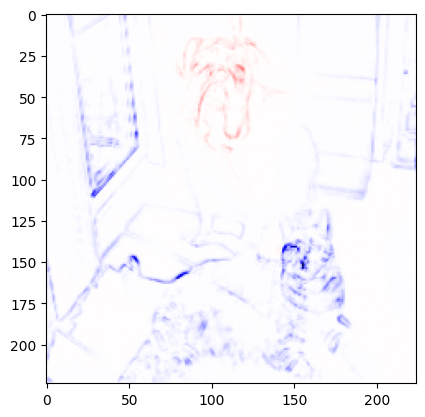

In [14]:

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [68]:
T = infer_pkg.simmaps['true_avgpool']

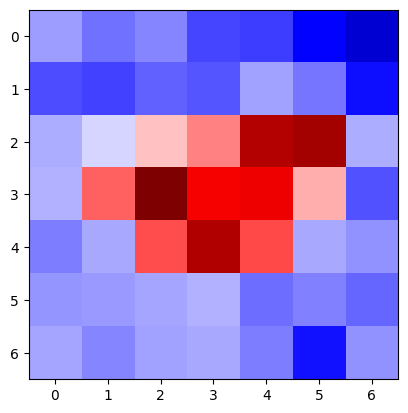

In [69]:

out = render.hm_to_rgb(T.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [108]:
t = infer_pkg.output_dict[target_layer_name]
zeb = t[:,:,3,2]
tus = t[:,:,3,3]
cos = nn.CosineSimilarity()
sim = cos(zeb,tus)
print(sim)

tensor([0.6243])


In [109]:
torch.norm(t[:,:,3,3])

tensor(40.7259)

In [13]:

out = render.hm_to_rgb(t.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

NameError: name 't' is not defined

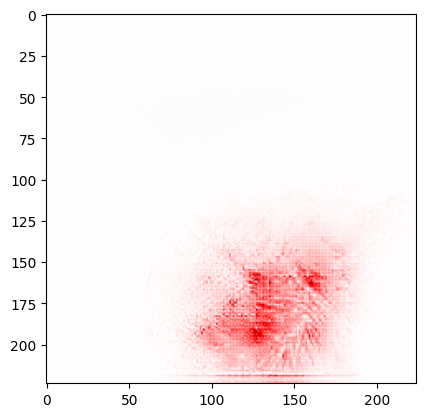

In [13]:

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [80]:
list(model_org.modules())[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [11]:
type(x)

torch.Tensor

In [9]:
simmap = torch.zeros((7,7))
inf = InferencePkg()
h = 7
w = 7
for _h in range(h):
    for _w in range(w):
        target_vector = infer_pkg.output_dict['resnet50.layer4.2.relu3'][:,:,_h,_w].cuda() / (h * w) # after avgpool
        out = model_org.fc(target_vector,inf)
        simmap[_h,_w] = out[0,282]



In [9]:
simmap.max()

tensor(0.5296, grad_fn=<MaxBackward1>)

In [11]:
simmap

tensor([[0.1538, 0.1656, 0.1680, 0.1070, 0.0690, 0.0353, 0.0414],
        [0.1241, 0.2478, 0.2934, 0.2739, 0.1843, 0.1071, 0.0714],
        [0.1076, 0.3980, 0.4562, 0.4806, 0.3457, 0.2554, 0.1104],
        [0.0882, 0.3042, 0.5001, 0.5296, 0.3678, 0.2668, 0.1428],
        [0.0566, 0.2341, 0.4270, 0.4506, 0.3502, 0.1957, 0.1508],
        [0.0499, 0.1562, 0.3095, 0.3137, 0.2236, 0.1907, 0.1607],
        [0.0447, 0.0807, 0.1520, 0.2106, 0.1811, 0.1630, 0.1297]],
       grad_fn=<CopySlices>)

In [89]:
simmap = torch.zeros((7,7))
inf = InferencePkg()
h = 7
w = 7
for _h in range(h):
    for _w in range(w):
        target_vector = infer_pkg.output_dict['resnet50.layer4.2.relu3'][:,:,_h,_w].cuda() / (h * w) # after avgpool
        out = model_org.fc(target_vector,inf)
        simmap[_h,_w] = out[0,34]


In [84]:
simmap

tensor([[ 0.0225,  0.0294,  0.0306, -0.0202, -0.0396, -0.0642, -0.0827],
        [ 0.0140,  0.0258,  0.0133, -0.0197, -0.0261, -0.0359, -0.0659],
        [-0.0236, -0.0082, -0.0126, -0.0113, -0.0147, -0.0171, -0.0362],
        [-0.0508, -0.0155,  0.0377,  0.0030,  0.0023, -0.0058, -0.0321],
        [-0.0621, -0.0432, -0.0046,  0.0167,  0.0618,  0.0366,  0.0026],
        [-0.0289, -0.0014,  0.0240,  0.0849,  0.0907,  0.0367,  0.0210],
        [ 0.0326,  0.0478,  0.0695,  0.0831,  0.0742,  0.0329,  0.0387]],
       grad_fn=<CopySlices>)

In [90]:
(simmap).max()

tensor(0.0907, grad_fn=<MaxBackward1>)

In [76]:
simmap.mean()

tensor(-0.0660, grad_fn=<MeanBackward0>)

In [60]:
simmap = simmap - simmap.mean()

In [91]:
simmap = simmap - simmap.max()/2

In [19]:
simmap[simmap < simmap.mean()] = 0

In [16]:
model_org.layer3[0].downsample

Sequential(
  (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [92]:
with torch.no_grad():
    o = simmap_obj()
    o.simmap = simmap.unsqueeze(0).to(infer_pkg.device)
    simmap = model_org.simprop2(x,o,infer_pkg)

In [11]:
with torch.no_grad():
    simmap = model_org.simprop(x,simmap,infer_pkg)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [9]:
simmap = torch.zeros((1,7,7)).to(infer_pkg.device)
simmap[0,5,5] = 1
o = simmap_obj()
o.simmap = simmap
with torch.no_grad():
    
    simmap = model_org.simprop2(x,o,infer_pkg)

In [14]:
simmap.shape

torch.Size([1, 224, 224])

In [18]:
simmap = torch.zeros((7,7))
simmap[5,5] = 1
with torch.no_grad():
    simmap = model_org.simprop(x,simmap,infer_pkg)

KeyboardInterrupt: 

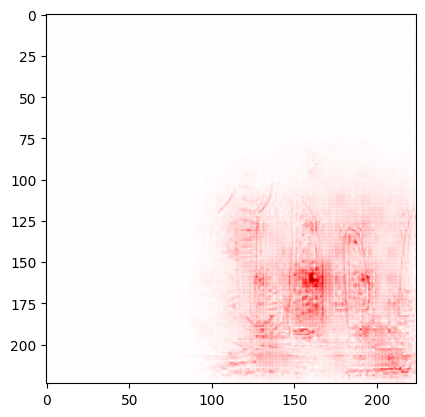

In [10]:

out = render.hm_to_rgb(simmap.squeeze().cpu().detach().numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)
#???? 엄청잘되네..? bias 영향 포함시키고.. 클래스 관해서 해봐야겠다.

In [11]:
model_org.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [13]:
_.shape

torch.Size([1, 1000])

In [12]:
model_org.layer1[0].downsample

Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
x.requires_grad = True
_y = model_org.gamma_forward(x,infer_pkg)
pred = _y.max(1, keepdim=False)[0]

#pred = _y[0,340]

pred.backward()

In [24]:
x.requires_grad = True
x = torch.zeros_like(x)
_y = model_org.gamma_forward(x,infer_pkg)
pred = _y.max(1, keepdim=False)[0]



In [50]:
model_org = resnet50(pretrained=True,name='resnet50').cuda()
model_org.eval()
target_layer = None
_ = model_org.gamma_forward(x,infer_pkg)
infer_pkg.use_external_gamma = False
for module in model_org.modules():
    if isinstance(module, torch.nn.modules.BatchNorm2d):
        if module.name == target_layer:
            pass
        else:
            nn.init.zeros_(module.running_mean)
            nn.init.zeros_(module.bias)

x,y = next(iter(val_loader))
x = x.to(device)
t = torch.zeros_like(x)
t[0,:,112,112] = x[0,:,112,112]
x.requires_grad = True
infer_pkg.use_external_gamma = True
with torch.no_grad():
    _y = model_org.gamma_forward(t,infer_pkg)
_y[0,243]

tensor(nan, device='cuda:0')

In [46]:
_y[0,243]

tensor(nan, device='cuda:0')

In [9]:
model_org = resnet50(pretrained=True,name='resnet50').cuda()
model_org.eval()
x,y = next(iter(val_loader))
x = x.to(device)
test = torch.zeros((224,224))
x.requires_grad = False
for module in model_org.modules():
    if isinstance(module, torch.nn.modules.BatchNorm2d):
       
        nn.init.zeros_(module.running_mean)
        nn.init.zeros_(module.bias)
for h in range(10,75):
    print(h)
    for w in range(75,140):
        with torch.no_grad():
            t = torch.zeros_like(x)
            t[0,:,h,w] = x[0,:,h,w]
            
            _y = model_org.decomp_forward(t,infer_pkg).cpu()
        test[h,w] = _y[0,243]

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [21]:
model_org = resnet50(pretrained=True,name='resnet50').cuda()
model_org.eval()
for module in model_org.modules():
    if isinstance(module, torch.nn.modules.BatchNorm2d):
       
        nn.init.zeros_(module.running_mean)
        nn.init.zeros_(module.bias)
x,y = next(iter(val_loader))
x = x.to(device)
t = torch.zeros_like(x)
t[0,:,32,98] = x[0,:,32,98]
with torch.no_grad():
    _y = model_org.decomp_forward(t,infer_pkg).cpu()

tensor(0.2910)
tensor(0.1016)
tensor(0.2715)
tensor(0.2559)
tensor(0.4155)
tensor(0.2891)
tensor(0.2559)
tensor(0.2725)
tensor(0.5117)
tensor(0.3086)
tensor(0.3154)
tensor(0.4336)
tensor(0.3750)
tensor(0.4131)
tensor(0.4023)
tensor(0.4102)
tensor(0.4365)
tensor(0.3867)
tensor(0.4531)
tensor(0.5859)
tensor(0.5742)
tensor(0.5859)
tensor(0.4844)
tensor(0.5000)
tensor(0.7656)
tensor(0.5938)
tensor(0.5000)
tensor(0.6250)
tensor(0.6406)
tensor(0.6289)
tensor(0.7656)
tensor(0.8672)
tensor(0.5039)
tensor(0.4922)
tensor(0.7109)
tensor(0.5039)


In [20]:
_y[0,243]

tensor(0.4061)

In [14]:
__ = test[10:75,75:140]

In [13]:
__.max()

tensor(0.4061)

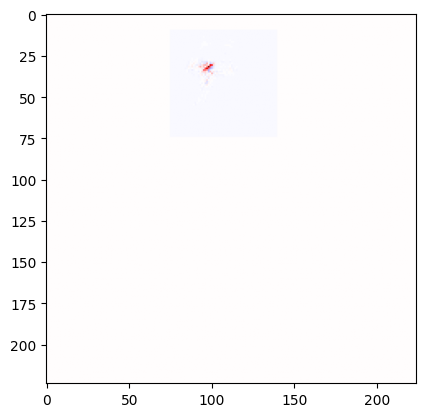

In [15]:

out = render.hm_to_rgb(test.numpy(), scaling=1, sigma=1, cmap='seismic')
plt.imshow(out)

In [43]:
x,y = next(iter(val_loader))
x = x.to(device)
x = x.to(torch.double)
x.requires_grad = True
_y = model_org(x,infer_pkg)
pred = _y.max(1, keepdim=False)[0]
pred.backward()
t = x * x.grad
t[0,:,10,75].sum()

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [17]:
_y.max(1, keepdim=False)[0]

tensor([11.4747], device='cuda:0', grad_fn=<MaxBackward0>)

In [18]:
pred

tensor([11.4747], device='cuda:0', grad_fn=<MaxBackward0>)

In [19]:
t = x * x.grad

#test = t[2,:,:].cpu().detach().numpy()

In [11]:
t.max()

tensor(0.2183, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)

In [12]:
y.max(1,keepdim=False)[1]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [21]:
t = t.squeeze()
b= t.sum(dim=0).cpu().detach().numpy()

In [23]:
b.max()

0.47392333

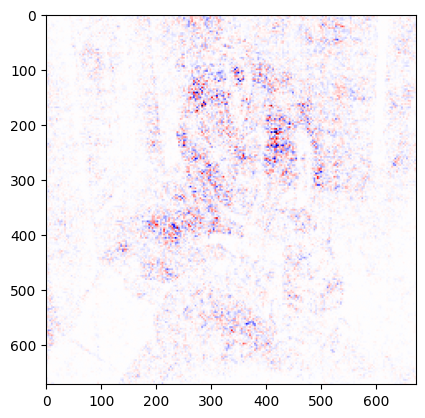

In [20]:
t = t.squeeze()
test = t.sum(dim=0).cpu().detach().numpy()
out = render.hm_to_rgb(test, scaling=3, sigma=1, cmap='seismic')
plt.imshow(out)

In [ ]:
#이것의 진짜 장점은..거꾸로 볼 수 있다는거다. 거꾸로 trace 해보자..
#bias 영향은 static만 떼서 보면 된다. 모든 레이어의 static 떼서 그림그려보자.. 224x224로 확대해서..